In [2]:
# Imports necessários
import sys

sys.path.insert(0, "../src")

import pickle

import matplotlib.pyplot as plt
import pandas as pd

# Import das funções do pipeline
from crypto_ts_forecast.pipelines.model_training.nodes import (
    create_model_report,
    evaluate_model,
    train_prophet_model,
)

## 1. Carregar Dados

In [3]:
# Carregar dados de treino e teste
prophet_full = pd.read_parquet("../data/04_feature/prophet_full.parquet")
train_data = pd.read_parquet("../data/05_model_input/train_data.parquet")
test_data = pd.read_parquet("../data/05_model_input/test_data.parquet")

print(f"Dados completos: {len(prophet_full)} registros")
print(f"Dados de treino: {len(train_data)} registros")
print(f"Dados de teste: {len(test_data)} registros")

Dados completos: 1825 registros
Dados de treino: 1795 registros
Dados de teste: 30 registros


## 2. Treinar Modelo Prophet

In [4]:
# Parâmetros do modelo
MODEL_PARAMS = {
    "seasonality_mode": "multiplicative",
    "yearly_seasonality": True,
    "weekly_seasonality": True,
    "daily_seasonality": False,
    "changepoint_prior_scale": 0.5,
    "seasonality_prior_scale": 10,
    "add_volume_regressor": False,
    "changepoint_range": 0.9,
}

print("Parâmetros do modelo:")
for key, value in MODEL_PARAMS.items():
    print(f"  - {key}: {value}")

Parâmetros do modelo:
  - seasonality_mode: multiplicative
  - yearly_seasonality: True
  - weekly_seasonality: True
  - daily_seasonality: False
  - changepoint_prior_scale: 0.5
  - seasonality_prior_scale: 10
  - add_volume_regressor: False
  - changepoint_range: 0.9


In [5]:
# Treinar modelo com todos os dados
print("Treinando modelo Prophet...")

model = train_prophet_model(
    train_data=prophet_full,  # Usar todos os dados
    **MODEL_PARAMS,
)

print("\nModelo treinado com sucesso!")

21:03:13 - cmdstanpy - INFO - Chain [1] start processing


Treinando modelo Prophet...


21:03:15 - cmdstanpy - INFO - Chain [1] done processing



Modelo treinado com sucesso!


## 2.1 Grid Search para Hiperparâmetros (Opcional)

Execute esta seção para encontrar os melhores hiperparâmetros usando validação cruzada.

In [ ]:
import itertools

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Grid de parâmetros para busca
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5],
    "seasonality_prior_scale": [1.0, 5.0, 10.0],
    "seasonality_mode": ["multiplicative", "additive"],
    "changepoint_range": [0.8, 0.9],
}

# Gerar todas as combinações
all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]
print(f"Total de combinações a testar: {len(all_params)}")

# Armazenar resultados
results = []

# Grid Search com Cross-Validation
RUN_GRID_SEARCH = True  # Mude para True para executar (pode demorar!)

if RUN_GRID_SEARCH:
    for i, params in enumerate(all_params):
        print(f"\n[{i + 1}/{len(all_params)}] Testando: {params}")

        try:
            # Criar e treinar modelo
            m = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                **params,
            )
            m.fit(prophet_full)

            # Cross-validation (últimos 60 dias, janelas de 30 dias)
            df_cv = cross_validation(
                m,
                initial="365 days",
                period="30 days",
                horizon="30 days",
                parallel="processes",
            )

            # Calcular métricas
            df_p = performance_metrics(df_cv)

            # Salvar resultado
            result = {
                **params,
                "mape": df_p["mape"].mean(),
                "rmse": df_p["rmse"].mean(),
                "mae": df_p["mae"].mean(),
            }
            results.append(result)
            print(f"   MAPE: {result['mape']:.4f}, RMSE: {result['rmse']:.2f}")

        except Exception as e:
            print(f"   Erro: {e}")
            continue

    # Criar DataFrame com resultados
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("mape")

    print("\n" + "=" * 60)
    print("TOP 5 MELHORES CONFIGURAÇÕES:")
    print("=" * 60)
    print(results_df.head())

    # Melhor configuração
    best_params = results_df.iloc[0].to_dict()
    print("\nMelhores parâmetros encontrados:")
    for k, v in best_params.items():
        if k not in ["mape", "rmse", "mae"]:
            print(f"   {k}: {v}")
else:
    print("Grid Search desativado. Mude RUN_GRID_SEARCH = True para executar.")
    print("   (Aviso: pode demorar vários minutos dependendo do tamanho dos dados)")

## 3. Avaliar Modelo

In [6]:
# Avaliar modelo no conjunto de teste
metrics = evaluate_model(
    model=model,
    test_data=test_data,
    add_volume_regressor=MODEL_PARAMS["add_volume_regressor"],
)

print("\nMétricas de Avaliação:")
print(f"  MAE: ${metrics['mae']:,.2f}")
print(f"  MAPE: {metrics['mape']:.2f}%")
print(f"  RMSE: ${metrics['rmse']:,.2f}")
print(f"  R²: {metrics['r2']:.4f}")


Métricas de Avaliação:
  MAE: $3,032.83
  MAPE: 3.43%
  RMSE: $3,739.39
  R²: -3.2638


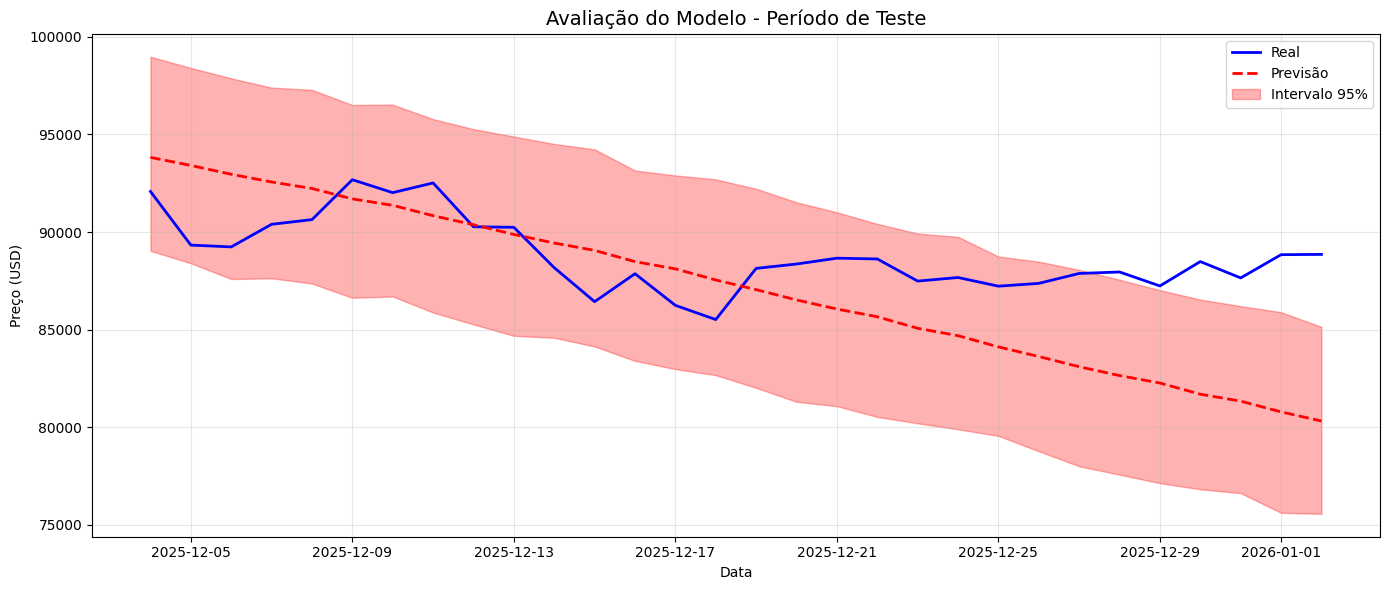

In [7]:
# Visualizar fit nos dados de teste
future_test = test_data[["ds"]].copy()
forecast_test = model.predict(future_test)

fig, ax = plt.subplots(figsize=(14, 6))

# Dados reais
ax.plot(test_data["ds"], test_data["y"], "b-", label="Real", linewidth=2)

# Previsão
ax.plot(
    forecast_test["ds"], forecast_test["yhat"], "r--", label="Previsão", linewidth=2
)

# Intervalo de confiança
ax.fill_between(
    forecast_test["ds"],
    forecast_test["yhat_lower"],
    forecast_test["yhat_upper"],
    alpha=0.3,
    color="red",
    label="Intervalo 95%",
)

ax.set_title("Avaliação do Modelo - Período de Teste", fontsize=14)
ax.set_xlabel("Data")
ax.set_ylabel("Preço (USD)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Criar Relatório do Modelo

In [8]:
# Criar relatório
report = create_model_report(
    metrics=metrics, train_data=prophet_full, test_data=test_data
)

print("Relatório do Modelo:")
import json

print(json.dumps(report, indent=2, default=str))

Relatório do Modelo:
{
  "model_type": "Prophet",
  "training_info": {
    "samples": 1825,
    "start_date": "2021-01-04 00:00:00",
    "end_date": "2026-01-02 00:00:00",
    "price_range": {
      "min": 15781.29,
      "max": 124658.54,
      "mean": 54488.53954520547
    }
  },
  "test_info": {
    "samples": 30,
    "start_date": "2025-12-04 00:00:00",
    "end_date": "2026-01-02 00:00:00"
  },
  "metrics": {
    "mae": 3032.828990858759,
    "mape": 3.430942341263425,
    "rmse": 3739.390759272846,
    "r2": -3.2637783323694958,
    "test_samples": 30,
    "test_start_date": "2025-12-04 00:00:00",
    "test_end_date": "2026-01-02 00:00:00"
  }
}


## 5. Visualizar Componentes do Modelo

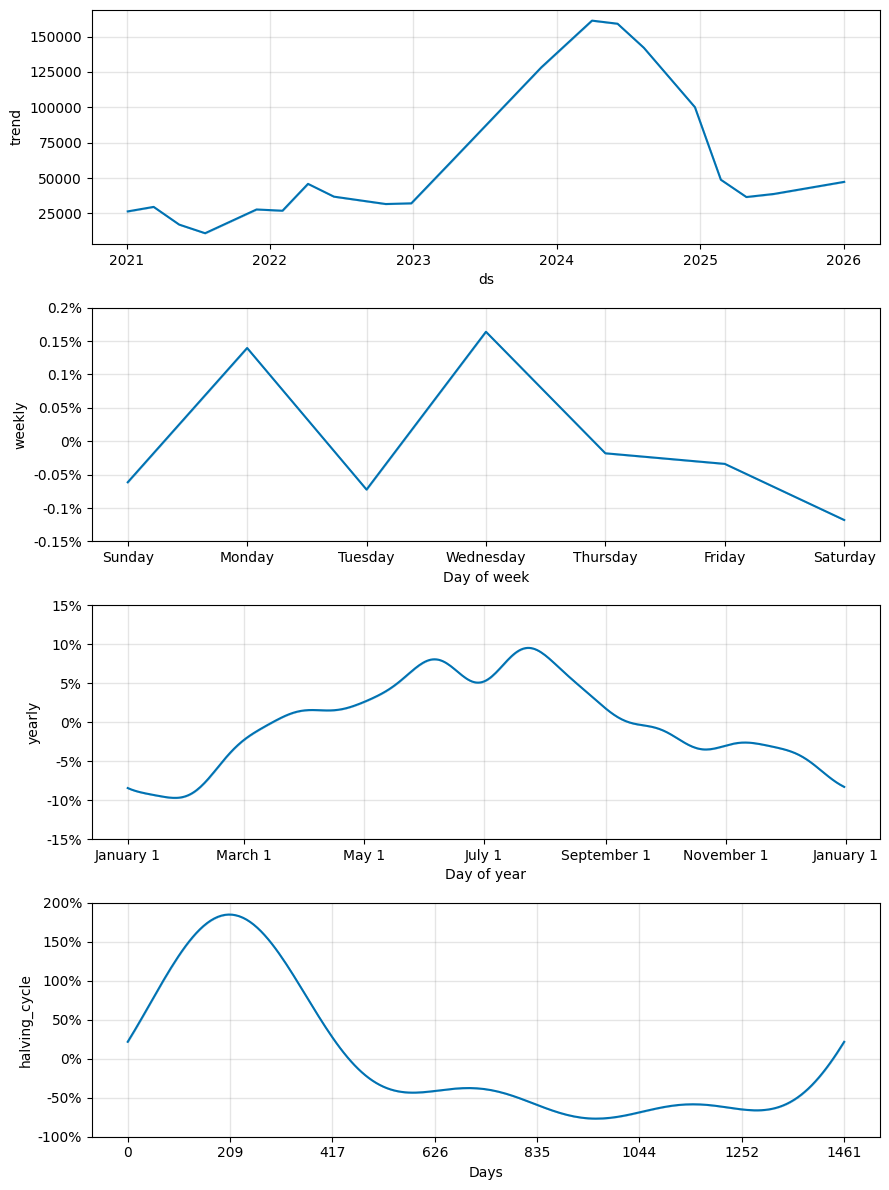

In [9]:
# Plot dos componentes do Prophet

# Fazer previsão em todos os dados para ver componentes
forecast_full = model.predict(prophet_full[["ds"]])

fig = model.plot_components(forecast_full)
plt.tight_layout()
plt.show()

In [11]:
# Salvar modelo
with open("../data/06_models/prophet_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Modelo salvo em data/06_models/prophet_model.pkl")

Modelo salvo em data/06_models/prophet_model.pkl
